# Stereo SLAM

This is a major part of this project and will likely take some time. 

For stereo, feel free to look up existing tutorials that implement this and write your own code here. Do not spend too long tweaking parameters here, focus on getting decent results and move on. You can also use OpenCV functions to backproject to 3D. 

In [1]:
# Import everything
import numpy as np
import cv2 as cv
import glob
import open3d as o3d
import copy
import pickle
# Matplotlib
from matplotlib import pyplot as plt

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


---

## Part 1: Stereo dense reconstruction

3-D point clouds are very useful in robotics for several tasks such as object detection, motion estimation (3D-3D matching or 3D-2D matching), SLAM, and other forms of scene understanding.  Stereo cameras provide  us  with  a  convenient  way  to  generate  dense  point  clouds. Dense here,  in  contrast  to sparse, means all the image points are used for the reconstruction.  In this part of the assignment you will be generating a dense 3D point cloud reconstruction of a scene from stereo images.


### Procedure


1. Generate a disparity map for each stereo pair.  Use OpenCV (e.g.  StereoSGBM) for this.  Note that the images provided are already rectified and undistorted.
2. Then, using the camera parameters and baseline information generate colored point clouds from each disparity map.  Some points will have invalid disparity values, so ignore them. Use `Open3D` for storing your point clouds.
3. Register (or transform) all the generated point clouds into your world frame by using the provided ground truth poses.
4. Visualize the registered point cloud data, in color.  Use Open3D for this.

    
    
Write briefly about how the disparity map is generated (if you used SGBM, write about SGBM).

### Task 1: Generate Disparity Map

Using two horizontally aligned cameras (having displacement only in the +X direction), we can construct a disparity map of the points (that we recognize in the two images).

<a href="https://docs.opencv.org/4.x/dd/d53/tutorial_py_depthmap.html">
    <img src="https://docs.opencv.org/4.x/stereo_depth.jpg" alt="Disparity Map image" style="display: block; margin-left: auto; margin-right: auto; width: 40%"/>
</a>

The points are matched using [Block Matching](https://en.wikipedia.org/wiki/Block-matching_algorithm). This allows for searching corresponding points. They must be horizontally aligned, i.e.: they lie on the same horizontal line with same $y$ value for the pixels. The difference in their x-value (for the pixels) in the two images is the disparity.

We can then get the depth of all pixels using the disparity $d$ as follows

$$ d = x - x' = \frac{Bf}{Z} \Rightarrow Z = \frac{Bf}{d} $$

The following references are given

- [OpenCV Tutorial on Disparity Maps](https://docs.opencv.org/4.x/dd/d53/tutorial_py_depthmap.html)
- [Choosing Good Stereo Parameters](https://wiki.ros.org/stereo_image_proc/Tutorials/ChoosingGoodStereoParameters) on roswiki
- Papers
    - [H Hirschmuller (2008) - Stereo Processing by Semiglobal Matching and Mutual Information](https://doi.org/10.1109/TPAMI.2007.1166) for `StereoSGBM`. Here, a more simple `StereoBM` is used.

In [2]:
# Adjust configurations for this task
# Folder names where left and right images are stored
left_imgs_folder = "./../data/img2/"
right_imgs_folder = "./../data/img3/"
# StereoBM (or StereoSGBM) object
stereo = cv.StereoBM_create(numDisparities=64, blockSize=15)

In [3]:
# Path to all images
l_imgs_path = glob.glob(left_imgs_folder + "*.png")
l_imgs_path.sort()
r_imgs_path = glob.glob(right_imgs_folder + "*.png")
r_imgs_path.sort()
assert len(l_imgs_path) == len(r_imgs_path), "Different L & R count"
left_imgs = []
right_imgs = []
# Fetch all of them
for limg_file, rimg_file in zip(l_imgs_path, r_imgs_path):
    limg = cv.imread(limg_file)
    rimg = cv.imread(rimg_file)
    left_imgs.append(limg)
    right_imgs.append(rimg)
# As numpy arrays [Sequence, Height, Width, Channel]
left_images = np.array(left_imgs)
right_images = np.array(right_imgs)

In [4]:
# Generate disparity maps
disp_maps = []
for imgL, imgR in zip(left_images, right_images):
    # Function works for grayscale images only
    disparity = stereo.compute(
        cv.cvtColor(imgL.copy(), cv.COLOR_BGR2GRAY),
        cv.cvtColor(imgR.copy(), cv.COLOR_BGR2GRAY))
    disp_maps.append(disparity)
# As numpy arrays
disparity_maps = np.array(disp_maps)

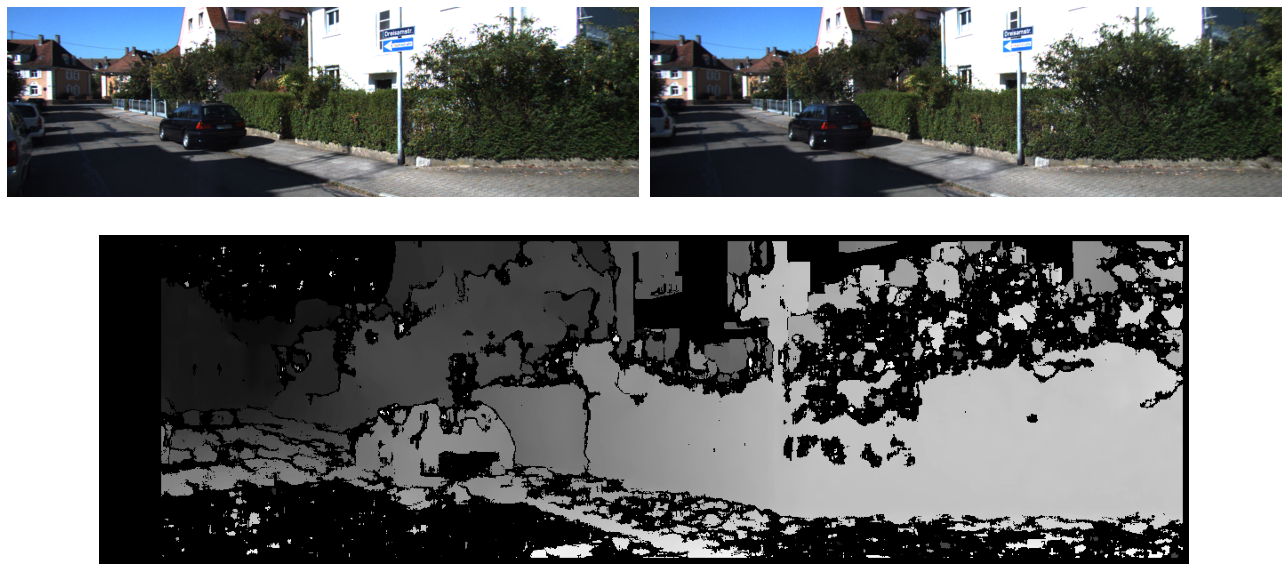

In [5]:
# Visualize the images and the disparity map
i = 10   # Set the pair to visualize
fig = plt.figure(figsize=(18, 9))
# fig.patch.set_facecolor('white')
plot_limg = plt.subplot2grid((2, 2), (0, 0))
l_img = plot_limg.imshow(left_images[i][:,:,::-1])
plt.axis('off')
plot_rimg = plt.subplot2grid((2, 2), (0, 1))
r_img = plot_rimg.imshow(right_images[i][:,:,::-1])
plt.axis('off')
plot_dmimg = plt.subplot2grid((2, 2), (1, 0), colspan=2)
dm_img = plot_dmimg.imshow(disparity_maps[i], cmap="gray")
plt.axis('off')
fig.tight_layout()

# def update(fnum):
#     i = int(fnum)
#     l_img.set_data(left_images[i][:,:,::-1])
#     r_img.set_data(right_images[i][:,:,::-1])
#     return l_img, r_img
# num_f = disparity_maps.shape[0]
# ani = FuncAnimation(fig, update, frames=list(range(num_f)))

plt.show()

The above plots look fine. These were derived for the following setting for the block matcher

```py
stereo = cv.StereoBM_create(numDisparities=64, blockSize=15)
```

For `i = 0`

![Disparity map for i = 0](./../results/stereo/part1/dm_0.png)

For `i = 10`

![Disparity map for i = 10](./../results/stereo/part1/dm_10.png)

For `i = 20`

![Disparity map for i = 20](./../results/stereo/part1/dm_20.png)

The important thing is that the building and some other artifacts are nicely visible in the depth map, this makes them more likely to be correctly recovered.

The cell below shows all the items in OpenCV which are related to `Stereo`

In [6]:
[elem for elem in dir(cv) if "Stereo" in elem]

['StereoBM',
 'StereoBM_PREFILTER_NORMALIZED_RESPONSE',
 'StereoBM_PREFILTER_XSOBEL',
 'StereoBM_create',
 'StereoMatcher',
 'StereoMatcher_DISP_SCALE',
 'StereoMatcher_DISP_SHIFT',
 'StereoSGBM',
 'StereoSGBM_MODE_HH',
 'StereoSGBM_MODE_HH4',
 'StereoSGBM_MODE_SGBM',
 'StereoSGBM_MODE_SGBM_3WAY',
 'StereoSGBM_create',
 'stereo_QuasiDenseStereo']

### Task 2: Generate Colored Point Clouds

**Reference**
- [cv.reprojectImageTo3D](https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html#ga1bc1152bd57d63bc524204f21fde6e02)
- Cyrill Stachniss YouTube Videos
    - [Triangulation for Image Pairs](https://youtu.be/UZlRhEUWSas)


#### For a fixed frame

Generating and visualizing the point clouds for the $k$th pair through disparity. Visualize them using color.

Once we know the disparity map, the following matrix transformation can be used to generate the point cloud (all using similar triangles)

$$ X = x' \frac{B}{\textup{d}_{x'-x''}} \qquad Y = y' \frac{B}{\textup{d}_{x'-x''}} \qquad Z = \frac{fB}{\textup{d}_{x'-x''}} $$

Note that we also have camera centers to take care of. So we change the above equations (to accommodate for camera centers) as follows

$$
X = \frac{(x' - w_c)B}{d_{x'-x''}} \qquad
Y = \frac{(y' - h_c)B}{d_{x'-x''}} \qquad
Z = \frac{fB}{d_{x'-x''}}
$$

Therefore, the new matrix operations can be summarized as follows

$$
\begin{bmatrix}
U \\ V \\ W \\ T
\end{bmatrix} = \begin{bmatrix}
B & 0 & 0 & -w_c B \\
0 & B & 0 & -h_c B \\
0 & 0 & 0 & Bf \\
0 & 0 & 1 & 0
\end{bmatrix} \begin{bmatrix}
x' \\ y' \\ d_{x'-x''} \\ 1
\end{bmatrix} \rightarrow \begin{matrix}
X = U \big/ T \\
Y = V \big/ T \\
Z = W \big/ T
\end{matrix}
$$

We will also apply a rotation so that the Z axis is up, X axis is front and Y axis is left. We additionally do two more things
1. Filter out the points at infinity (say when they have zero disparity for very far off points) or points that are `nan` (for whatever reason)
2. Color the points using the corresponding pixel color values in the left image

In [7]:
# Test the point cloud generation for one frame (LR pair)
k = 5  # Test value
h, w, _ = left_images[k].shape
f = 7.070912e+02
B = 0.53790448812
Q = np.array([
    [B, 0, 0, -(w/2)*B],
    [0, B, 0, -(h/2)*B],
    [0, 0, 0, B*f],
    [0, 0, 1, 0]
], np.float32)
a = (disp_maps[k]-np.min(disp_maps[k]))/np.ptp(disp_maps[k])
a = (a*255).astype(np.uint8)
points = cv.reprojectImageTo3D(a, Q)    # Generate Point Cloud: h,w,3
pts = points.reshape(-1, 3) # Shape: -1,3
fi = np.all(np.isfinite(pts), axis=1)   # Indices of finite values
ptsf = pts[fi]
rotm = np.array([[0, 0, 1], [-1, 0, 0], [0, -1, 0]])
ptsf_tf = (rotm @ ptsf.T).T
limg = left_images[k]   # Image (for color)
cvs = limg.reshape(-1, 3)   # All pixel color values
color_vals = cvs[fi]/255    # Color values
color_vals = color_vals[:,[2,1,0]]  # BGR to RGB

In [8]:
# Visualize using Open3D
pcd = o3d.geometry.PointCloud()
cf = o3d.geometry.TriangleMesh.create_coordinate_frame(0.5)
pcd.points = o3d.utility.Vector3dVector(ptsf_tf)
pcd.colors = o3d.utility.Vector3dVector(color_vals)
o3d.visualization.draw_geometries([pcd, cf], 
    window_name=f"Point Cloud - {k}", lookat=[0, 0, 0], up=[0, 0, 1], 
    front=[-1, -0.1, 0.25], zoom=0.01)

For different values of `k`, the following were observed

- `k = 0`

    <img src="../results/stereo/part1/pc_k0.png" alt="k = 0 point cloud" width=400 />

    Notice the car in the front right in the scene is nicely projected as a point cloud

- `k = 10`

    <img src="../results/stereo/part1/pc_k10.png" alt="k = 10 point cloud" width=400 />

    Notice the bush forming the curved plane (at the side of the road). It is noticeably curving well (as it appears in the images)

- `k = 20`

    <img src="../results/stereo/part1/pc_k20.png" alt="k = 20 point cloud" width=400 />

    Notice the black car in the front got registered well. Even some building surfaces are visible.

Note that there are some outliers (specially the points in the sky). These can be ignored for now

#### For all frames

In this section such point clouds are generated and stored in appropriate variables.

In [9]:
# Configurations (from calib.txt)
f = 7.070912e+02        # Focal length
B = 0.53790448812       # Baseline

The following variables are declared below. Only the filtered data is recorded.

| Variable Name | Type (see: [typing](https://docs.python.org/3/library/typing.html)) | Description |
| :---: | :---- | :---- |
| `pts_cam` | `list[np.ndarray]` | List of Point clouds in camera frame. The origin is the center of camera projection. Y is down the picture, X is to the right (Z is into the picture). Shape of each element is `N, 3`. |
| `pts_std` | `list[np.ndarray]` | List of Point clouds in a standard frame. The frame is X axis front (where camera's Z axis was), Z axis up (where camera's -Y axis was), and Y axis to left (where camera's -X axis was). The origin is the same as the camera's frame. |
| `pts_rgbcolors` | `list[np.ndarray]` | List of point colors of the point clouds. Columns are in RGB format. Pixel color is taken from the left image. Indices correspond to `pts_cam`. Each value is `0-255`. |
| `pcso3d_nocolor` | `list[o3d.geometry.PointCloud]` | List of point clouds in Open3D format (vectorized containers). Point clouds are in standard frame (that of `pts_std`). The `colors` attribute is not set (default height). |
| `pcso3d_color` | `list[o3d.geometry.PointCloud]` | List of point clouds in Open3D format (vectorized containers). Point clouds are in standard frame (that of `pts_std`). The `colors` attribute is set to the corresponding values in `pts_rgbcolors`. |
| `rpts_cam` | `list[np.ndarray]` | The raw points returned by the `reprojectImageTo3D` function. This **can have invalid points** (that are unfiltered). Shape of each element is `H, W, 3`. |

In the end of this section, the variables of type `list[np.ndarray]` are written to a file using [pickle](https://docs.python.org/3/library/pickle.html#module-pickle).


In [10]:
# Objects to log (for future use)
rpts_cam = []   # Raw points in camera frame (unfiltered)
pts_cam = []    # Points in camera frame
pts_std = []    # Points in standard frame
pts_rgbcolors = []  # RBG point colors
pcso3d_nocolor = [] # As Open3D point clouds
pcso3d_color = []   # Colored Open3D point clouds

# Rotation matrix: Represent 'Camera' in 'Standard' frame
rotm = np.array([[0, 0, 1], [-1, 0, 0], [0, -1, 0]])
# For each frame
for k, dmap in enumerate(disp_maps):
    # Spatial triangulation matrix
    h, w, _ = left_images[k].shape
    Q = np.array([ [B, 0, 0, -(w/2)*B], [0, B, 0, -(h/2)*B], 
        [0, 0, 0, B*f], [0, 0, 1, 0] ], np.float32)
    # Disparity (to uint8 map, as are pixels)
    dn = (((dmap-np.min(dmap))/np.ptp(dmap))*255).astype(np.uint8)
    # Point cloud (just a matrix multiplication)
    points = cv.reprojectImageTo3D(dn, Q)    # shape: h, w, 3
    pts = points.reshape(-1, 3) # -1, 3
    # Image pixel colors
    limg = left_imgs[k] # shape: h, w, 3
    cvs = limg.reshape(-1, 3)   # shape: h*w, 3
    cvs = cvs[:,[2,1,0]]   # BGR to RGB (OpenCV to Open3D and others)
    # Filter out invalid points
    fi = np.all(np.isfinite(pts), axis=1)
    ptsf = pts[fi]  # Valid points
    ptsf_colors = cvs[fi]   # Corresponding colors
    # Transform into standard frame
    ptsf_std = (rotm @ ptsf.T).T    # N, 3 points in {standard}
    # Open3D objects
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(ptsf_std)
    pcd_color = o3d.geometry.PointCloud()
    pcd_color.points = o3d.utility.Vector3dVector(ptsf_std)
    ncvs = ptsf_colors/255  # Normalized color values (0 to 1)
    pcd_color.colors = o3d.utility.Vector3dVector(ncvs)
    # Save to variables
    rpts_cam.append(copy.deepcopy(points))
    pts_cam.append(copy.deepcopy(ptsf))
    pts_std.append(copy.deepcopy(ptsf_std))
    pts_rgbcolors.append(copy.deepcopy(ptsf_colors))
    pcso3d_nocolor.append(copy.deepcopy(pcd))
    pcso3d_color.append(copy.deepcopy(pcd_color))

Testing this out

In [11]:
cf = o3d.geometry.TriangleMesh.create_coordinate_frame(0.5)
o3d.visualization.draw_geometries([pcso3d_color[20], cf],
    window_name="Point Cloud", lookat=[0, 0, 0], up=[0, 0, 1], 
    front=[-1, -0.1, 0.25], zoom=0.01)

Save all `np.ndarray` lists using pickle (`o3d.geometry.PointCloud` cannot be pickled). Set `save_file` to True if you want to save the current run.

In [12]:
# Save as dict using pickle
file_name = "./../results/stereo/part1/raw_datadict.pkl"
save_file = False
data_obj = {
    "rpts_cam": rpts_cam,
    "pts_cam": pts_cam,
    "pts_std": pts_std,
    "pts_rgbcolors" : pts_rgbcolors
}
# If save
if save_file:
    with open(file_name, 'wb') as fhdlr:
        pickle.dump(data_obj, fhdlr)
else:
    print("Not saving pickle")

Not saving pickle


### Task 3: Register Point Clouds in World

Using the given `poses.txt` file (which contains odometry), transform the point clouds from each odometry frame to the world frame (starting frame in odometry).

---

## Part 2: Motion estimation using iterative PnP

Using the generated reconstruction from the previous part, synthesize a new image taken by a virtualmonocular camera fixed at any arbitrary position and orientation.  Your task in this part is to recoverthis pose using an iterative Perspective-from-n-Points (PnP) algorithm. 

### Procedure: 

<ol>
    <li> Obtain a set of 2D-3D correspondences between the the image and the point cloud.  Since hereyou’re generating the image, this should be easy to obtain. </li>
    <li> For this set of correspondences compute the total reprojection error c= $\sum_{i} ‖x_i−P_{k}X_i‖^2 $    where $P_{k}= K[R_{k}|t_{k}]$, $X_{i}$ is the 3D point in the world frame, $x_{i}$ is its corresponding projection. </li>
    <li> Solve for the pose $T_{k}$ that minimizes this non-linear reprojection error using a Gauss-Newton (GN)scheme.  Recall that in GN we start with some initial estimated value $x_{o}$ and iteratively refine the estimate using $x_{1}$= $∆x+x_0$, where $∆x$ is obtained by solving the normal equations $J^{T}J∆x$= -$J^{T}e$, until convergence.The main steps in this scheme are computing the corresponding Jacobians and updating the estimates correctly.  For our problem,  use a 12×1 vector parameterization for $T_{k}$(the top 3×4submatrix).  Run the optimization for different choices of initialization and report your observations. </li>
</ol>

Make sure that you write about how you calculate the residual and jacobians. Do not just include the code. The pose that you have been given is the ground truth, so using that will obviously give good results for optimization, so try out something else as well.

## Part 3: Odometry Calculation

In part 1, you used the ground truth pose for registration. Here, try to estimate the pose using the RGB image data alone. 

### Procedure:

1. This can be done by computing features across the two images and matching them. Since you already have the depth map, you now have correspondences between the depth maps of two images as well from the RGB feature matches. 
2. You can now convert this depth map to a point cloud.
3. Since you have correspondences between image points in the depth map, you have 3D correspondences here as well. Perform ICP here to get a good pose estimate.
4. Feed these initial pose estimates into the PnP pipeline and optimise further.